## Getting started
Load the libraries used in this notebook.

In [162]:
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
import time

In [163]:
GRIDID = "grid.6906.9" # Erasmus University Rotterdam

## 1 Simple Topics Analysis: top concepts in publications about 'design' 

> GOAL: we want to extract the most frequent topics from a dataset generated by searching for the keyword 'design' in publications where authors are from University of Rotterdam

Concepts scoring

The list of concepts from each publication (eg [a, b, c, d, f, g..]) is ordered by most-relevant first. 

Since scores are not returned, we assing a number to each concept automatically, so that it reflects its position in the list. The first concept gets the highest number. 

This way we can then combine concepts from multiple publications. 


In [164]:
data = dslqueryall(f"""search publications in title_abstract_only for "design" where research_orgs.id="{GRIDID}" return publications[concepts+year]""")
print(data.stats)
test = json_normalize(data.publications)
test.head()

1000 / 1870
1870 / 1870
{'total_count': 1870}


,concepts,year
0,"[Netherlands, registration, trial registers, C...",2019
1,"[contextual factors, homecare, nursing homes, ...",2019
2,"[configuration, transitive closure, design, Ba...",2019
3,"[reference, Ferdinand Marcos, article, state i...",2019
4,"[workflow interruptions, knowledge, CDSS, clin...",2019


### Extracting the most important concepts

Let's take the first 20 concepts from each publication. 

In order to merge/sort them, we assing also a score (1..20) based on their position (first=20). 

We also set up a `cleanup` function to automatically remove uninteresting concepts. 

In [179]:
def cleanup(concepts):
    blacklist = ['study', 'results', 'design', 'paper', 'effect', 'method', 'approach', 'findings', 'purpose', 'levels', 'years', 'review', 'example']
    o = []
    for x in concepts:
        if x not in blacklist and (not x.isupper()):
            o.append(x)
    return o
        
def concepts_extractor(dsl_results, cleanup=True, n=20):
    df = pd.DataFrame(columns=['concept', 'score', 'year'])
    for x in dsl_results:
        if 'concepts' in x:
            concepts = x['concepts'][:n]
            if cleanup:
                concepts = cleanup(concepts)
            if concepts:
                llen = len(concepts)
                scores = list(range(1, llen+1))[::-1] # highest score first
                years = [x["year"]] * llen
                z = list(zip(concepts, scores, years))
                d = [{'concept': a, 'score': b, 'year': c} for a,b,c in z]
                df = df.append(d, sort=True)
    return df

df = concepts_extractor(data.publications, cleanup=True)            
df.head()
# df[df['concept']=="AD"]

,concept,score,year
0,Netherlands,17,2019
1,registration,16,2019
2,trial registers,15,2019
3,Compulsive Scale,14,2019
4,measures,13,2019


## Findings: Top concepts - Absolute terms 

In [180]:
df_by_concept = df.groupby('concept', as_index=False).sum()
df_by_concept = df_by_concept.sort_values(by="score",  ascending=False)
df_by_concept.reset_index(drop=True)
df_by_concept.head()

,concept,score,year
3864,data,1380,317064
10361,patients,1299,272429
4230,differences,1277,260777
6253,groups,1264,254687
777,Netherlands,1131,238776


In [181]:
df_by_concept.describe()

,score,year
count,15349.000000,15349.000000
mean,20.237996,4256.500293
std,56.028656,11835.155795
min,1.000000,1973.000000
25%,6.000000,2001.000000
50%,11.000000,2012.000000
75%,17.000000,2018.000000
max,1380.000000,317064.000000


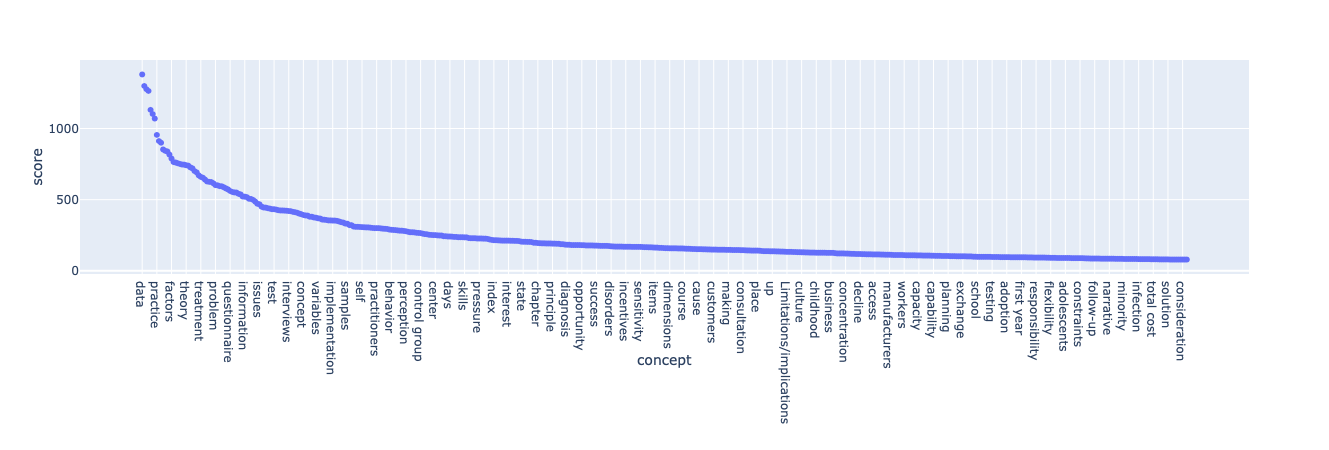

In [182]:
px.scatter(df_by_concept.head(500), x="concept", y="score")

## Findings: Top concepts - Segmented by year

In [183]:
df_by_year = df.groupby(['year', 'concept'], as_index=False).sum()
df_by_year = df_by_year.sort_values(by=["year", "score"],  ascending=False)
df_by_year.reset_index(drop=True)
df_by_year.head()

,year,concept,score
25996,2019,theory,97
25341,2019,data,93
25669,2019,model,88
25534,2019,implementation,73
25166,2019,article,66


In [184]:
df_by_year.describe()

,year,score
count,26074.000000,26074.000000
mean,2006.781506,11.913515
std,9.005677,10.047076
min,1973.000000,1.000000
25%,1999.000000,6.000000
50%,2009.000000,11.000000
75%,2015.000000,16.000000
max,2019.000000,162.000000


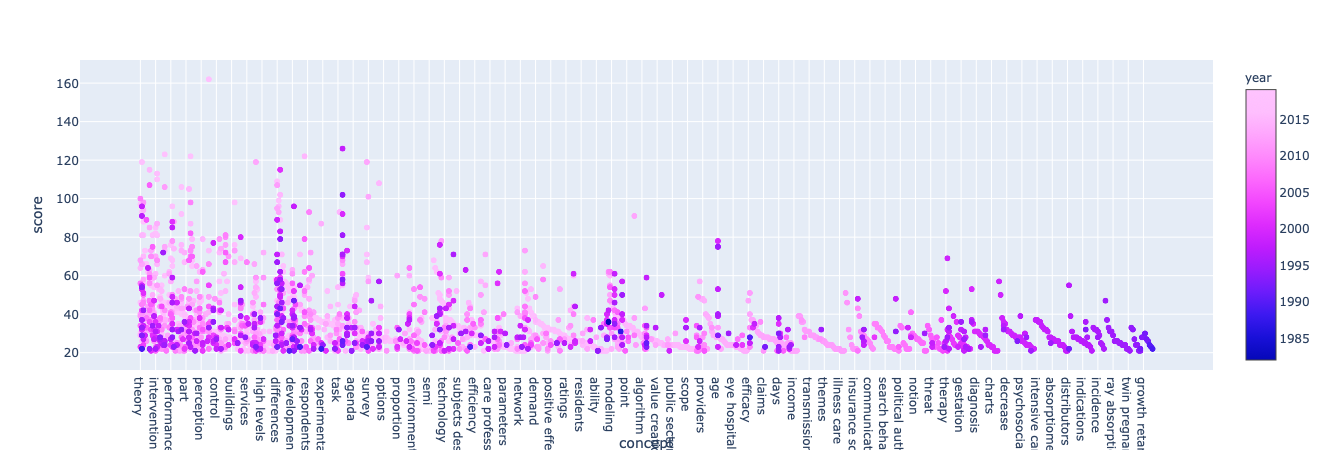

In [202]:
px.scatter(df_by_year.query("score>20"), x="concept", y="score", color="year")

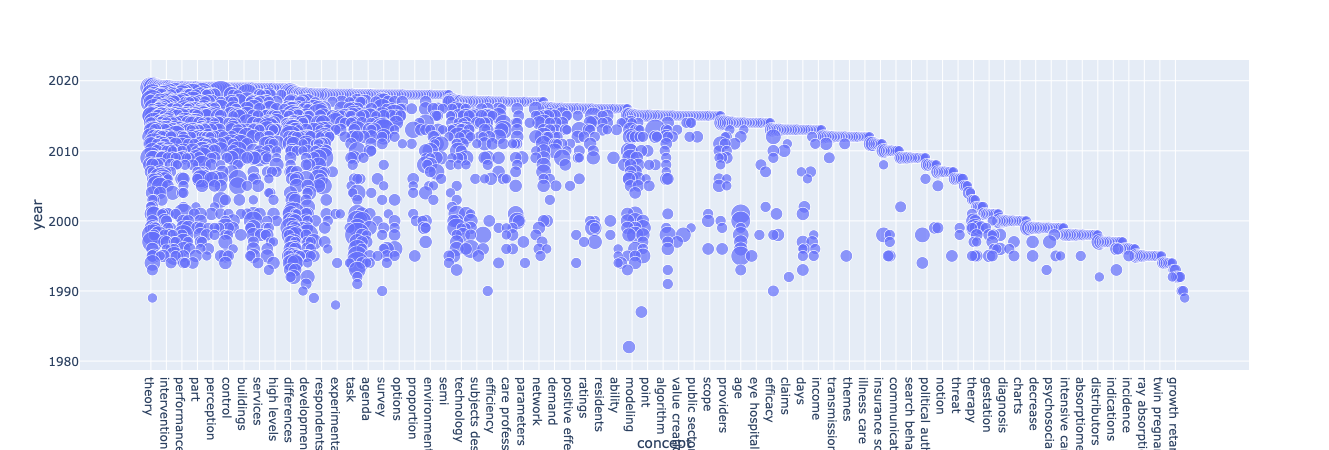

In [203]:
px.scatter(df_by_year.query("score>20"), x="concept", y="year", size="score")

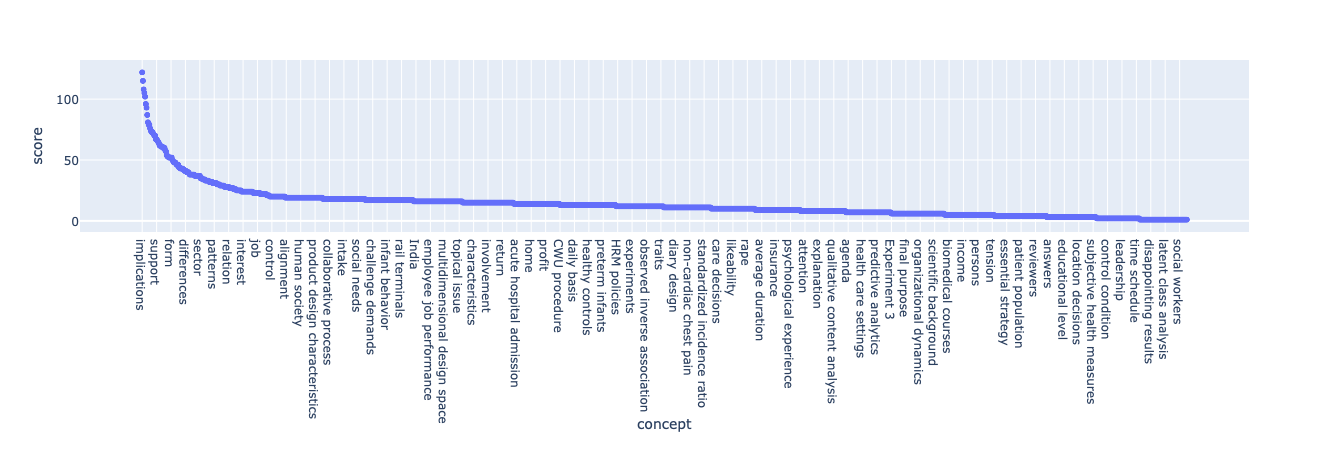

In [212]:
px.scatter(df_by_year.query("year==2015"), x="concept", y="score")

### 3 Topics Analysis: related institutions, funders, patents via the top concepts

```
=> top institutions 
=> top funders 
=> top patents 

```